In [1]:
# Standard Imports
import numpy as np
from time import time
import pandas as pd
from matplotlib import pyplot as plt

# SHAPER
from src.Observables import Observable
from src.Shaper import Shaper
from src.Manifolds import Coordinates2D, Simplex

# Utils
from utils.data_utils import load_cmsopendata, load_dataset, calculate_masses, normalize_events, add_pileup
from utils.plot_utils import plot_event
from ot.lp import emd2

# Jets
from pyjet import cluster



# GPU nonsense
import torch 
import torch.nn as nn

if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 


/home/rikab/miniconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Using CPU!


# Data

(10000, 200, 3)
(10000, 200, 3)
652.7005


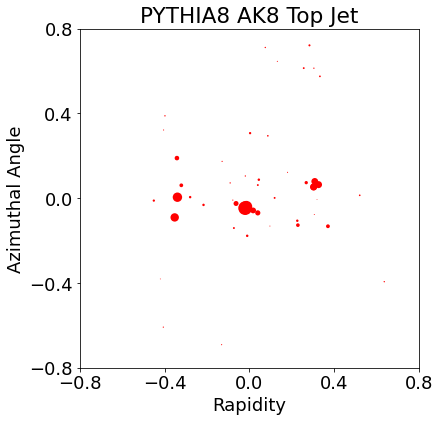

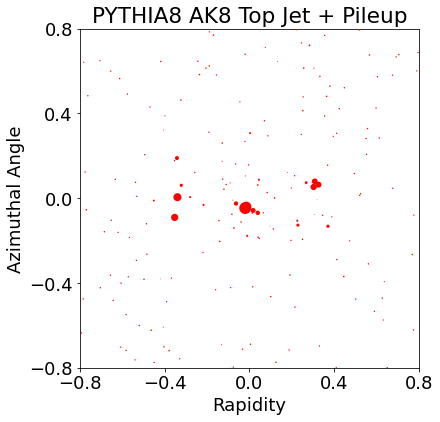

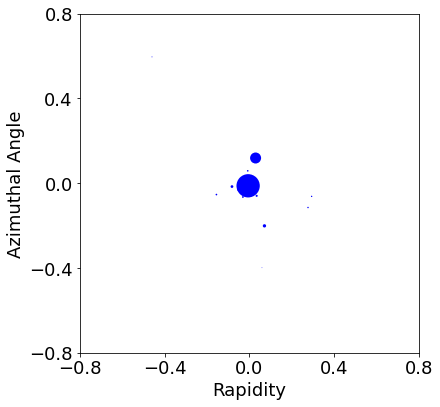

174.12473412154915 19.0730630191373
0.3874491338168036 0.033670873820744095


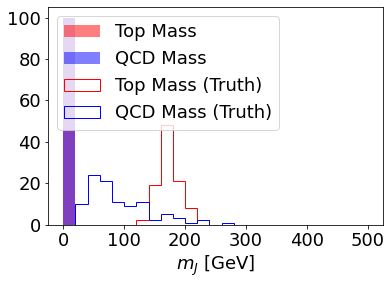

(array([ 3.,  5.,  4.,  9., 16., 21., 27., 10.,  3.,  2.]),
 array([-226.59001398, -216.63466996, -206.67932595, -196.72398194,
        -186.76863793, -176.81329392, -166.85794991, -156.90260589,
        -146.94726188, -136.99191787, -127.03657386]),
 <BarContainer object of 10 artists>)

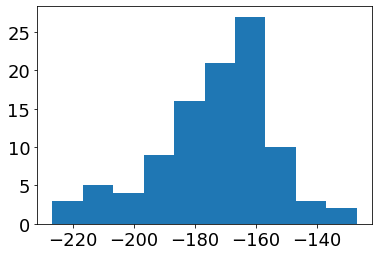

In [2]:
# Parameters
R = 0.8
beta = 1
N = 100

mass_lower = 0
mass_upper = np.inf
pt_lower = 475
pt_upper = 525
eta = 1.9
quality = 2
pad = 125
plot_dir = "results"



# cms, cms_weights = load_cmsopendata("data", "cms", pt_lower, pt_upper, eta, quality, pad, n = N)
# sim, sim_weights, sim_factors = load_cmsopendata("data", "sim", pt_lower, pt_upper, eta, quality, pad, n = N)
# print(cms_weights.shape)
# events = (cms, sim)


# Load events
signal = load_dataset("../Datasets/top/v0/signal_train.npy", N, mass_lower, mass_upper, eta, normalize = False)
background = load_dataset("../Datasets/top/v0/background_train.npy", N, mass_lower, mass_upper, eta, normalize = False)
signal_mass = calculate_masses(signal)
background_mass = calculate_masses(background)


# Add pileup
signal_pu = normalize_events(add_pileup(signal, 100, 50, 250, 25, R))
background_pu = normalize_events(add_pileup(background, 100, 50, 250, 25, R))
signal_pu_mass = calculate_masses(signal_pu)
background_pu_mass = calculate_masses(background_pu)



events = [signal, background]
event_labels = ["signal", "background"]
colors = ["red", "blue"]




# Example plots
example_signal = signal[0]
example_signal_pu = signal_pu[0]
print(example_signal[1].sum())
plot_event(example_signal[0], example_signal[1], R, color = "red", title = "PYTHIA8 AK8 Top Jet", filename= "Plots/top.pdf")
plot_event(example_signal_pu[0], example_signal_pu[1], R, color = "red", title = "PYTHIA8 AK8 Top Jet + Pileup", filename = "Plots/top_pileup.pdf")

example_background = background[0]
plot_event(example_background[0], example_background[1], R, color = "blue")

print(np.mean(signal_mass), np.std(signal_mass))
print(np.mean(signal_pu_mass), np.std(signal_pu_mass))


plt.hist(signal_pu_mass, color = "red", bins = 25, range = [0, 500], label = "Top Mass", alpha = 0.5, histtype="stepfilled")
plt.hist(background_pu_mass, color = "blue", bins = 25, range = [0, 500], label = "QCD Mass", alpha = 0.5, histtype="stepfilled")
plt.hist(signal_mass, color = "red", bins = 25, range = [0, 500], label = "Top Mass (Truth)", alpha = 1.0, histtype="step")
plt.hist(background_mass, color = "blue", bins = 25, range = [0, 500], label = "QCD Mass (Truth)", alpha = 1.0, histtype="step")
plt.legend(loc = "upper left")
plt.xlabel(r"$m_J$ [GeV]")
plt.show()

ns = [1, 2, 4, 8, 16, 32]
epsilons = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]


plt.hist(signal_pu_mass - signal_mass)



(6, 6, 500)
[0.1989448070526123, 0.32617616653442383, 0.2633833885192871, 0.5637409687042236, 3.242915391921997]
[0.17659211158752441, 0.2806892395019531, 0.23235344886779785, 0.48673558235168457, 2.750175714492798]
[0.156541109085083, 0.25180959701538086, 0.20213675498962402, 0.4096076488494873, 2.256305694580078]
[0.1376802921295166, 0.14257073402404785, 0.2631962299346924, 0.3358128070831299, 1.7810816764831543]
[0.11684465408325195, 0.12029910087585449, 0.2314131259918213, 0.2587003707885742, 1.2896318435668945]
[0.09727096557617188, 0.09851670265197754, 0.20116376876831055, 0.18235206604003906, 0.7922673225402832]


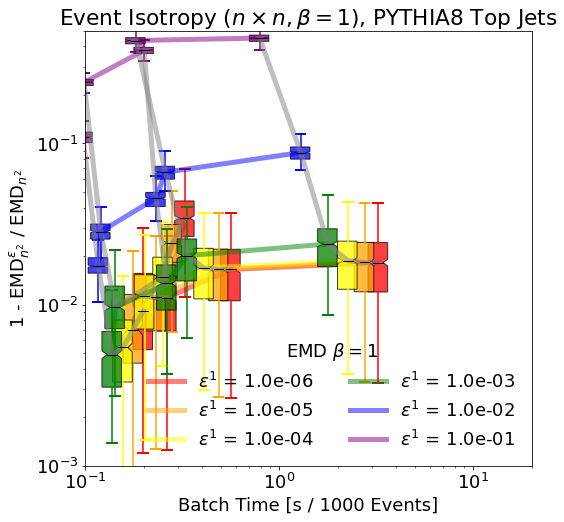

(6, 6, 500)
[0.1423957347869873, 0.14295434951782227, 0.26511120796203613, 0.33583712577819824, 1.7798912525177002]
[0.126753568649292, 0.1319732666015625, 0.2469196319580078, 0.29633045196533203, 1.5298898220062256]
[0.11663222312927246, 0.12059950828552246, 0.23221349716186523, 0.25777530670166016, 1.2855110168457031]
[0.10630154609680176, 0.10921001434326172, 0.21584343910217285, 0.2199995517730713, 1.0351366996765137]
[0.09709906578063965, 0.09858274459838867, 0.20109987258911133, 0.1810770034790039, 0.7885985374450684]
[0.08626794815063477, 0.08762359619140625, 0.1862659454345703, 0.1426377296447754, 0.5408096313476562]


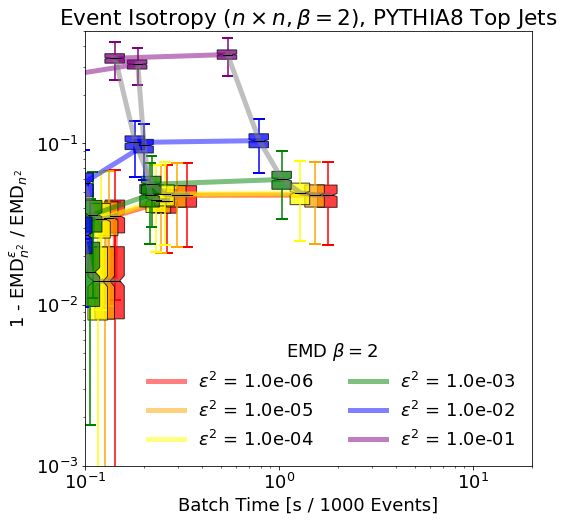

In [3]:
ns = [1, 2, 4, 8, 16, 32]
epsilons = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]

def plot_times(dataset, beta, xlim, ylim):

    emds_sinkhorn = np.load("data/%s_%d_isotropy_emds_sinkhorn.npy" % (dataset, beta))
    times_sinkhorn = np.load("data/%s_%d_isotropy_times_sinkhorn.npy" % (dataset, beta))
    emds_pot = np.load("data/%s_%d_isotropy_emds_pot.npy" % (dataset, beta))

    accuracies = beta * emds_sinkhorn / emds_pot[None,:,:] * (R**beta)

    accuracies = accuracies[:,1:,:]
    times_sinkhorn = 1*times_sinkhorn[:,1:]
    print(emds_sinkhorn.shape)
    # times_sinkhorn[:,2] = times_sinkhorn[:,2] / 2



    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    plt.rcParams['font.size'] = '18'
    lims = [0, 1.0]
    colors = ["red", "orange", "yellow", "green", "blue", "purple"]

    w = 0.1
    width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)


    for (e, eps) in enumerate(epsilons):

        print(times_sinkhorn[e].tolist())
        bp = ax.boxplot((1-accuracies[e]).tolist(), positions = times_sinkhorn[e], showfliers=False, patch_artist = True, notch=True, widths=width(times_sinkhorn[e],w),)

        for i,patch in enumerate(bp['boxes']):
            patch.set(color = colors[e], alpha = 0.75, edgecolor= "black")

        for whisker in bp['whiskers']:
            whisker.set(color =colors[e],
                        linewidth = 1.5,
                        # linestyle =":"
                        )
        
        # changing color and linewidth of
        # caps
        for cap in bp['caps']:
            cap.set(color = colors[e],
                    linewidth = 2)
        
        # changing color and linewidth of
        # medians
        for median in bp['medians']:
            median.set(color = "black",
                    linewidth = 1)


        average = np.median(1-accuracies[e], axis = 1)
        plt.plot(times_sinkhorn[e], average, color = colors[e],label = "$\epsilon^{%d}$ = %.1e" % (beta,eps), alpha = 0.5, linewidth = 5)
        # plt.axhline(np.sqrt(epsilons[e]), color = colors[e], label = "$\epsilon^2$ = %.1e" % eps, linewidth = 10, alpha = 0.10)


    for (i, n) in enumerate(ns[1:]):
        average = np.median(1-accuracies[:,i,:], axis = 1)
        plt.plot(times_sinkhorn[:,i], average, color = "gray", alpha = 0.5, linewidth = 5)


        # plt.boxplot(accuracies[e].tolist(), positions=times_sinkhorn[e].tolist())

    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel("Batch Time [s / 1000 Events]")
    plt.ylabel("1 - EMD$^\epsilon_{n^2}$ / EMD$_{n^2}$")
    plt.title(r"Event Isotropy $(n \times n, \beta = %d)$, PYTHIA8 Top Jets" % beta)
    plt.legend(title = r"EMD $\beta = %d$" % beta, loc = "lower right", ncol = 2, frameon = False)
    # plt.ylabel(r"$\mathcal{I}_{%d}^{\epislon} / \mathcal{I}_{%d}$" % (n**2, n**2) )
    # plt.show()
    plt.savefig("Plots/isotropy_%d.pdf" % beta)
    plt.show()

plot_times("signal_pu", 1, (1e-1, 2e1), (1e-3, 5e-1))
plot_times("signal_pu", 2, (1e-1, 2e1), (1e-3, 5e-1))


# plot_times("signal_pu", 1, (1e-0, 1e3), (1e-4, 5e-1))
# plot_times("signal_pu", 2, (1e-0, 5e2), (1e-3, 5e-1))


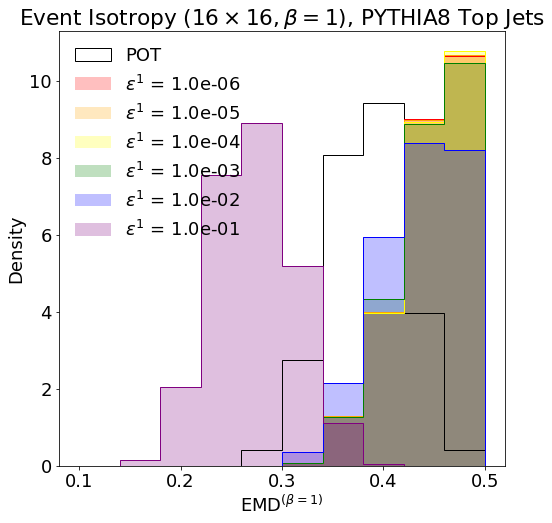

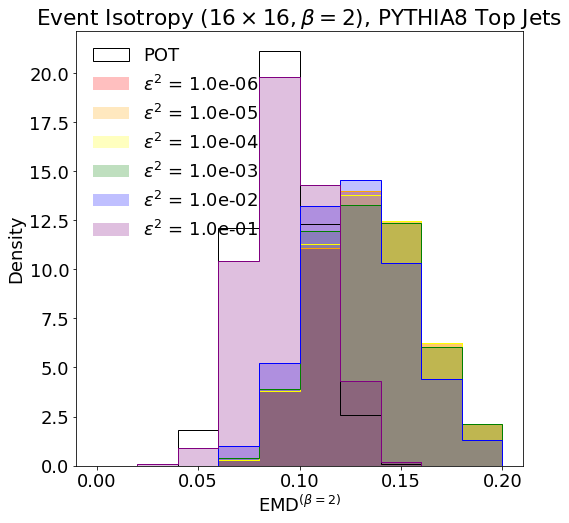

In [4]:
# Plot absolute distributions:

def absolute_hist(beta, lims):

    dataset = "signal_pu"

    emds_sinkhorn = np.load("data/%s_%d_isotropy_emds_sinkhorn.npy" % (dataset, beta))
    times_sinkhorn = np.load("data/%s_%d_isotropy_times_sinkhorn.npy" % (dataset, beta))
    emds_pot = np.load("data/%s_%d_isotropy_emds_pot.npy" % (dataset, beta))

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    plt.rcParams['font.size'] = '18'
    
    
    colors = ["red", "orange", "yellow", "green", "blue", "purple"]
    bins = 10
    
    plt.hist(emds_pot[-2] / beta, bins = bins, range = lims, density= True, label = "POT", color = "black", histtype="step")
    for (e, eps) in enumerate(epsilons):
        plt.hist(emds_sinkhorn[e,-2], bins = bins, range = lims, density= True, color = colors[e], histtype="step")
        plt.hist(emds_sinkhorn[e,-2], bins = bins, range = lims, density= True, label = "$\epsilon^{%d}$ = %.1e" % (beta,eps), color = colors[e], alpha = 0.25)

    plt.xlabel(r"EMD$^{(\beta  = %d)}$" % beta)
    plt.ylabel("Density")
    plt.title(r"Event Isotropy $(16\times 16, \beta = %d)$, PYTHIA8 Top Jets" % beta)
    plt.legend(frameon = False)
    plt.savefig("Plots/isotropy_hist_%d.pdf" % beta)
    plt.show()
    plt.close()


    # ROC curve
    

absolute_hist(1, (0.1, 0.5))
absolute_hist(2, (0.0, 0.2))

In [5]:
# plt.hist(signal_emds["2 Subjettiness"] / signal_emds["1 Subjettiness"] , bins = 25, range = [0,1], density = True, color = "red", histtype="stepfilled", alpha = 0.25, label = "Top Jets")
# plt.hist(background_emds["2 Subjettiness"] / background_emds["1 Subjettiness"] , bins = 25, range = [0,1], density = True, color = "blue", histtype="stepfilled", alpha = 0.25, label = "QCD Jets")
# plt.legend()
# plt.show()

# plt.hist(signal_emds["3 Subjettiness"] / signal_emds["2 Subjettiness"] , bins = 25, range = [0,1], density = True, color = "red", histtype="stepfilled", alpha = 0.25, label = "Top Jets")
# plt.hist(background_emds["3 Subjettiness"] / background_emds["2 Subjettiness"] , bins = 25, range = [0,1], density = True, color = "blue", histtype="stepfilled", alpha = 0.25, label = "QCD Jets")
# plt.legend()

# Becnhmarks - Gradients

In [6]:

# Define N-Subjettiness
Ns = np.arange(1,4)
observables = {}

# Sample at N weighted Dirac deltas
def point_sampler(N, param_dict):
    return (param_dict["Points"].params, param_dict["Weights"].params)

for n in Ns:

    _nsubjettiness = Observable({"Points" : Coordinates2D(n), "Weights" : Simplex(n)}, point_sampler, beta = 1, R = 0.8, initializer= "kt")
    observables["%d-Subjettiness" % n] = _nsubjettiness

# Define Isotropy
def build_reference_event(n):
    points, zs = [], []
    for y in np.linspace(-R,R, n):
            for phi in np.linspace(-R, R, n):

                    points.append((y, phi))
                    zs.append(1.0 / (n**2))

    refernce_event = (np.array(points), np.array(zs))
    return refernce_event

reference_event = build_reference_event(16)

def isotropy_samples(n, param_dict, dtype=torch.FloatTensor):

        zs = torch.from_numpy(reference_event[1]).type(dtype)
        points = torch.from_numpy(reference_event[0]).type(dtype)
        return (points, zs)

observables["Isotropy"] = Observable({}, isotropy_samples, beta = 1, R = 0.8) 

shaper = Shaper(observables, device)
shaper.to(device)
signal_emds, signal_params, Fs, dxs = shaper.calculate(signal_pu, epochs = 500, verbose=True, lr = 0.01, scaling = 0.9, epsilon = 0.001, early_stopping= 25, N = 500, return_grads=True)
background_emds, background_params, _, _ = shaper.calculate(background_pu, epochs = 500, verbose=True, lr = 0.01, scaling = 0.9, epsilon = 0.001, early_stopping= 25, N = 500, return_grads=True)


Observable: 1-Subjettiness Epoch 0 Mean Loss = 0.3945220245420933 Elapsed time = 3.534s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 1 Mean Loss = 0.39135412767529487 Elapsed time = 5.949s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 2 Mean Loss = 0.38879403814673424 Elapsed time = 8.245s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 3 Mean Loss = 0.38673911929130556 Elapsed time = 10.560s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 4 Mean Loss = 0.3850083218514919 Elapsed time = 12.720s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 5 Mean Loss = 0.3835750637948513 Elapsed time = 15.319s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 6 Mean Loss = 0.38242134511470793 Elapsed time = 17.371s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 7 Mean Loss = 0.3814785726368427 Elapsed time = 19.343s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 8 Mean Loss = 0.380743885487318 Elapsed time = 21.510s

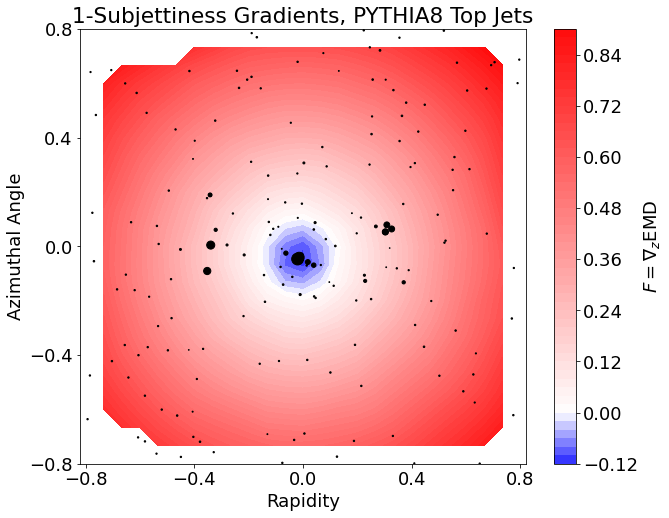

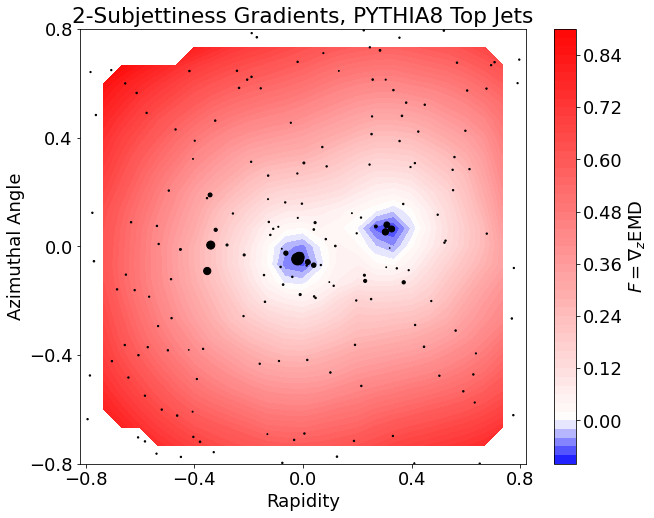

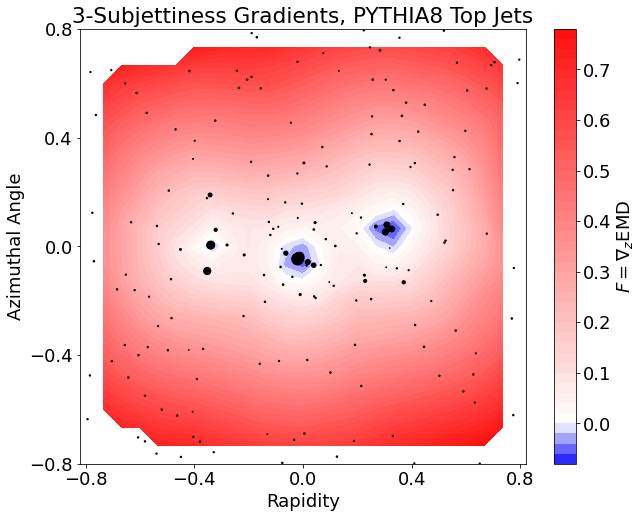

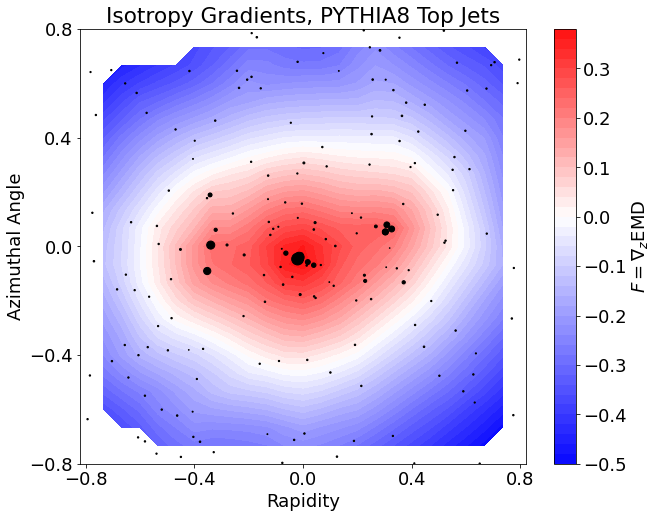

(187, 2)


NameError: name 'F' is not defined

In [7]:
from scipy.interpolate import griddata
import matplotlib.colors as colors


def grad_plot(obs):
    i = 0
    event = signal_pu[i]
    F = Fs[obs][i][:event[1].shape[0]]
    emd = signal_emds[obs][i]

    energy_uncertainty = 0.15 * event[1]
    var2 = np.sum(np.power(F,2) * np.power(energy_uncertainty,2))




    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    plt.rcParams['font.size'] = '18'



    xi = np.linspace(-R, R, 25)
    yi = np.linspace(-R, R, 25)
    xi, yi = np.meshgrid(xi, yi)
    zi = griddata((event[0][:,0],event[0][:,1]), F, (xi, yi),method='linear')

    # ax.scatter(event[0][:,0],event[0][:,1], color = "black", alpha = abs(F) / max(abs(F)))
    # plt.contourf(xi, yi, zi, 15, colors = "k", linewidths = 0.5)


    norm = colors.TwoSlopeNorm(vmin=min(F), vcenter=0, vmax=max(F))

    plt.contourf(xi, yi, zi, 50, cmap = plt.get_cmap("bwr"), norm = norm)


    ax.scatter(event[0][:,0],event[0][:,1], color = "black", s = 1000* event[1] /sum(event[1]))

    cbar = plt.colorbar() 
    cbar.set_label(r"$F = \nabla_z$EMD")
    # plt.scatter(x, y, marker = 'o', c = 'b', s = 10, zorder = 10)
    plt.xlim(-R, R)
    plt.ylim(-R, R)
    plt.axis('equal')
    # plt.text(-0.5, 0.45, "EMD = %.e $\pm$ %.3e" % (emd, np.sqrt(var2)))
    # plt.text(-0.5, 0.40, "Assuming 10\% uncorrelated uncertainties")
    # plt.text(-0.5, 0.35, r"$\beta = $ %d" % beta)

    plt.xlabel('Rapidity')
    plt.ylabel('Azimuthal Angle')
    plt.title("%s Gradients, PYTHIA8 Top Jets" % obs)

    plt.xticks(np.linspace(-R, R, 5))
    plt.yticks(np.linspace(-R, R, 5))

    ax.set_aspect('equal')
    # plt.zlabel(r"$F = \nabla_z$EMD")

    plt.savefig("Plots/%s_Gradient.pdf" %obs)
    plt.show()
    plt.close()


def quiver_plot(obs):

    i = 0
    event = signal_pu[i]
    dx = dxs[obs][i][:event[1].shape[0]]
    emd = signal_emds[obs][i]

    print(dx.shape)

    energy_uncertainty = 0.15 * event[1]
    var2 = np.sum(np.power(F,2) * np.power(energy_uncertainty,2))




    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    plt.rcParams['font.size'] = '18'



    xi = np.linspace(-R, R, 20)
    yi = np.linspace(-R, R, 20)
    xi, yi = np.meshgrid(xi, yi)
    dxi = griddata((event[0][:,0],event[0][:,1]), dx, (xi, yi),method='linear')
    dxi = np.nan_to_num(dxi)
    norm = np.sqrt(dxi[:,:,0]**2 + dxi[:,:,1]**2)
    dxi = dxi / np.sqrt(dxi[:,:,0]**2 + dxi[:,:,1]**2)[:,:,None]

    print(dxi.shape)
    print(norm.shape)
    print((norm / np.nanmax(np.abs(norm))).shape)

    ax.quiver(xi, yi, dxi[:,:,0], dxi[:,:,1], color = "red",  alpha = np.sqrt(norm / np.nanmax(np.abs(norm)),) , width = 0.01 )
    ax.scatter(event[0][:,0],event[0][:,1], color = "black", s = 1000* event[1] /sum(event[1]))

    plt.xlim(-R, R)
    plt.ylim(-R, R)
    plt.axis('equal')
    # plt.text(-0.5, 0.45, "EMD = %.e $\pm$ %.3e" % (emd, np.sqrt(var2)))
    # plt.text(-0.5, 0.40, "Assuming 10\% uncorrelated uncertainties")
    # plt.text(-0.5, 0.35, r"$\beta = $ %d" % beta)

    plt.xlabel('Rapidity')
    plt.ylabel('Azimuthal Angle')
    plt.title("%s Gradients, PYTHIA8 Top Jets" % obs)

    plt.xticks(np.linspace(-R, R, 5))
    plt.yticks(np.linspace(-R, R, 5))

    ax.set_aspect('equal')
    # plt.zlabel(r"$F = \nabla_z$EMD")

    plt.savefig("Plots/%s_Quiver.pdf" % obs)
    plt.show()
    plt.close()

grad_plot("1-Subjettiness")
grad_plot("2-Subjettiness")
grad_plot("3-Subjettiness")
grad_plot("Isotropy")


quiver_plot("1-Subjettiness")
quiver_plot("2-Subjettiness")
quiver_plot("3-Subjettiness")
quiver_plot("Isotropy")

# print(F.shape)
# N = int(np.sqrt(len(F)))
# F = F.view(N, N)
# F = np.nan_to_num(F)

# # And display it with contour lines:
# # levels = np.linspace(-1, 1, nlines)
# ax.contourf(
#     F,
#     origin="lower",
#     linewidths=2.0,
#     colors="jet",
# )

In [ ]:
plt.hist(signal_emds["2-Subjettiness"] / signal_emds["1-Subjettiness"] , bins = 25, range = [0,1], density = True, color = "red", histtype="stepfilled", alpha = 0.25, label = "Top Jets")
plt.hist(background_emds["2-Subjettiness"] / background_emds["1-Subjettiness"] , bins = 25, range = [0,1], density = True, color = "blue", histtype="stepfilled", alpha = 0.25, label = "QCD Jets")
plt.legend()
plt.show()

plt.hist(signal_emds["3-Subjettiness"] / signal_emds["2-Subjettiness"] , bins = 25, range = [0,1], density = True, color = "red", histtype="stepfilled", alpha = 0.25, label = "Top Jets")
plt.hist(background_emds["3-Subjettiness"] / background_emds["2-Subjettiness"] , bins = 25, range = [0,1], density = True, color = "blue", histtype="stepfilled", alpha = 0.25, label = "QCD Jets")
plt.legend()

In [ ]:
import scipy.stats as stats


uncertainy = .15
zis = np.random.normal(loc=1.0, scale= uncertainy, size=(250, event[1].shape[0]))


uncertain_events = []
for i in range(250):

    e = (event[0], (zis[i] * event[1]) / np.sum(zis[i] * event[1]))
    uncertain_events.append(e)

uncertain_emds, uncertain_params = shaper.calculate(uncertain_events, epochs = 500, verbose=True, lr = 0.01, scaling = 0.9, epsilon = 0.001, early_stopping= 25, N = 500, return_grads=False)

bins = 10
lims = [0.030, 0.036]
binwidth = (lims[1]-lims[0]) / bins
x = np.linspace(lims[0], lims[1], 100)
plt.plot(x, stats.norm.pdf(x, emd, np.sqrt(var2)) , label = "Gradient Prop")
plt.hist(uncertain_emds["Isotropy_16"], bins = bins, label = "Resampling", density = True)
plt.axvline(emd, color = "red", label = "Event EMD")
plt.title("Poor Man's Unfolding - Single Event ")
plt.xlabel("EMD")
plt.legend()

# Benchmarks - Apollonius

In [ ]:
# Interpolate between max subjettiness, ---rhos--- isotropy
rhos = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
observables = {"MAX Subjettiness": _MAXsubjettiness}
for rho in rhos:
    _apollonius = (_MAXsubjettiness + _isotropy)
    _apollonius.freeze("Joint Weights", np.array([1 - rho, rho]))
    observables["Apollonius %d" % (rho * 10)] = _apollonius
observables["Isotropy"] = _isotropy

shaper = Shaper(observables)

# print(signal[0][1])
cms_emds, _ = shaper.calculate(cms, epochs = 500, verbose=True, lr = 0.01, scaling = 0.5, epsilon = 0.01, early_stopping= 5)
sim_emds, _ = shaper.calculate(sim, epochs = 500, verbose=True, lr = 0.01, scaling = 0.5, epsilon= 0.01, early_stopping= 5)
_ = 0

In [ ]:
from matplotlib.lines import Line2D

plt.figure(figsize=(6, 6))
plt.rcParams['font.size'] = '12'

sg_ys = []
sg_errs = []
bg_ys = []
bg_errs = []

# print(signal_emds, background_emds)

for (i, rho) in enumerate(rhos):
    sg_ys.append(np.mean(cms_emds["Apollonius %d" %i]))
    sg_errs.append(np.std(cms_emds["Apollonius %d" %i]))
    bg_ys.append(np.mean(sim_emds["Apollonius %d" %i]))
    bg_errs.append(np.std(sim_emds["Apollonius %d" %i]))

plt.errorbar(np.array(rhos) + 0.01, sg_ys, yerr = sg_errs, color = "red", label = "Top Jets")
plt.errorbar(rhos, bg_ys, yerr = bg_errs, color = "blue", label = "QCD Jets")

# plt.axhline(np.mean(signal_emds["MAX Subjettiness"]), color = "black")
plt.axhline(np.mean(cms_emds["Isotropy"]), color = "red", linestyle = "--")
plt.axhline(np.mean(sim_emds["Isotropy"]), color = "blue", linestyle = "--")


custom_legend = [Line2D([0], [0], color = "red", lw = 2, label = "CMS Jets"),
                 Line2D([0], [0], color = "blue", lw = 2, label = "SIM Jets"),
                 Line2D([0], [0], color = "black", lw = 2, ls = "--", label = r"Isotropy $(\beta = 1)$"),]
plt.legend(handles = custom_legend)
plt.xlabel(r"$\rho$")
plt.ylabel("EMD")
plt.title("Apollonius EMD Distribution")

# TODO: Make rainbow plot CMS vs Pythia plot of N-subjettiness for many Ns 

In [ ]:
range = [.2, 1.0]
plt.figure(figsize=(6, 6))
plt.rcParams['font.size'] = '12'

def plot_hist(obs, color, label):

    bins = 25
    counts,bin_edges = np.histogram(cms_emds[obs] / np.max(cms_emds[obs]),bins = bins, range = range, weights= cms_weights)
    step = bin_edges[1] - bin_edges[0]
    errs2 = np.histogram(cms_emds[obs] / np.max(cms_emds[obs]), bins=bins, weights=cms_weights*cms_weights)[0]
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
    
    plt.errorbar(bin_centres, counts, yerr = np.sqrt(errs2), xerr = step / 2, fmt='o', color = color, label = r"CMS " + label)
    plt.hist(sim_emds[obs] / np.max(sim_emds[obs] ), bins = 25, weights = sim_weights * sim_factors, range = range, color = color, alpha = 0.25, lw = 3, histtype= "step", label = r"SIM " + label)



plot_hist("Apollonius 2", "red", r"$\rho = 0.2$")
plot_hist("Isotropy", "blue", "Isotropy")
# plot_hist("Apollonius 6", "yellow")
# plot_hist("Apollonius 8", "green")
# plot_hist("Apollonius 10", "blue")


xlabel = r'Apollonius EMD / Max'
ylabel = 'Differential Cross Section [nb]'
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title('Apollonius Distributions')
plt.legend()


In [ ]:
# How far is each event from its (normalized) corrected event?

for rho in rhos:
    observables["Apollonius %d" % (rho * 10)].freeze("Weights")
    observables["Apollonius %d" % (rho * 10)].freeze("Joint Weights")

# Benchmarks - Nsubjettiness

In [ ]:
# Interpolate between max subjettiness, ---rhos--- isotropy
N = np.arange(1,126)
observables = {}
for n in N:

    _nsubjettiness = Observable({"Points" : Coordinates2D(n), "Weights" : Simplex(n)}, point_sampler, beta = 1, R = 0.8, initializer= "kt")
    observables["%d-Subjettiness" % n] = _nsubjettiness

shaper = Shaper(observables)

# print(signal[0][1])
cms_njettiness, _ = shaper.calculate(cms, epochs = 25, verbose=True, lr = 0.01, scaling = 0.5, epsilon = 0.01, early_stopping= 5)
sim_njettiness, _ = shaper.calculate(sim, epochs = 25, verbose=True, lr = 0.01, scaling = 0.5, epsilon= 0.01, early_stopping= 5)

In [ ]:
from matplotlib.lines import Line2D

plt.figure(figsize=(6, 6))
plt.rcParams['font.size'] = '12'



cms_njettiness["0-Subjettiness"] = np.zeros_like(cms_njettiness["1-Subjettiness"])
sim_njettiness["0-Subjettiness"] = np.zeros_like(sim_njettiness["1-Subjettiness"])

# print(signal_emds, background_emds)

sg_ys = []
sg_errs = []
bg_ys = []
bg_errs = []

for n in N:
    sg_ys.append(np.mean(np.nan_to_num(cms_njettiness["%d-Subjettiness" % n] / cms_njettiness["%d-Subjettiness" % (n-1)], 1.0)))
    sg_errs.append(np.std(cms_njettiness["%d-Subjettiness" % n]/ cms_njettiness["%d-Subjettiness" % (n-1)])*0)
    bg_ys.append(np.mean(np.nan_to_num(sim_njettiness["%d-Subjettiness" % n] / sim_njettiness["%d-Subjettiness" % (n-1)], 1.0)))
    bg_errs.append(np.std(sim_njettiness["%d-Subjettiness" % n] / sim_njettiness["%d-Subjettiness" % (n-1)])*0)


print(len(sg_ys), N.shape)

plt.errorbar(N + 0.1, sg_ys, yerr = sg_errs, color = "red", label = "Top Jets")
plt.errorbar(N, bg_ys, yerr = bg_errs, color = "blue", label = "QCD Jets")

# # plt.axhline(np.mean(signal_emds["MAX Subjettiness"]), color = "black")
# plt.axhline(np.mean(signal_emds["Isotropy"] * 0.95), color = "red", linestyle = "--")
# plt.axhline(np.mean(background_emds["Isotropy"] * 0.94), color = "blue", linestyle = "--")


custom_legend = [Line2D([0], [0], color = "red", lw = 2, label = "Top Jets"),
                 Line2D([0], [0], color = "blue", lw = 2, label = "QCD Jets"),
                #  Line2D([0], [0], color = "black", lw = 2, ls = "--", label = r"Isotropy $(\beta = 1)$"),
                 ]
plt.legend(handles = custom_legend)
plt.xlabel(r"$N$")
plt.ylabel("EMD")
# plt.yscale("log")
plt.ylim([0,1])
plt.title("N-Subjettiness EMD Distribution")

# TODO: Make rainbow plot CMS vs Pythia plot of N-subjettiness for many Ns 

In [ ]:
range = [0, 1]
plt.figure(figsize=(8, 8))
plt.rcParams['font.size'] = '12'

def plot_hist(obs, color, label):

    bins = 25
    counts,bin_edges = np.histogram(cms_njettiness[obs] / np.max(cms_njettiness[obs]),bins = bins, range = range, weights= cms_weights)
    step = bin_edges[1] - bin_edges[0]
    errs2 = np.histogram(cms_njettiness[obs] / np.max(cms_njettiness[obs]), bins=bins, weights=cms_weights*cms_weights)[0]
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
    
    plt.errorbar(bin_centres, counts, yerr = np.sqrt(errs2), xerr = step / 2, fmt='o', color = color, label = r"CMS " + label)
    plt.hist(sim_njettiness[obs] / np.max(cms_njettiness[obs] ), bins = 25, weights = sim_weights * sim_factors, range = range, color = color, alpha = 0.25, lw = 3, histtype= "step", label = r"SIM " + label)



# plot_hist("1-Subjettiness", "red", r"$N = 1$")
# plot_hist("2-Subjettiness", "orange", r"$N = 2$")
# plot_hist("3-Subjettiness", "yellow", r"$N = 3$")
# plot_hist("5-Subjettiness", "green", r"$N = 5$")
# plot_hist("10-Subjettiness", "blue", r"$N = 10$")
# plot_hist("25-Subjettiness", "purple", r"$N = 25$")
plot_hist("50-Subjettiness", "black", r"$N = 50$")

# plot_hist("Apollonius 6", "yellow")
# plot_hist("Apollonius 8", "green")
# plot_hist("Apollonius 10", "blue")


xlabel = r'N-Jettiness / Max'
ylabel = 'Differential Cross Section [nb]'
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title('Apollonius Distributions')
plt.legend()